In [1]:
from vqvae import VQVAE


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

import numpy as np

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 6. Visualize a Few Test Images and Their Predictions
def visualize_predictions(images):

    # Plot the images and predicted labels
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.show()

In [3]:

# 1. Load and Preprocess the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    # transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

# Download and load the Fashion-MNIST training and test dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

TrainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Class labels for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [4]:
K =  128 # size of the CodeBook
D =  32 # dimension of each embedding vector
in_channels = 1 # gray scale image  = 1 color channel
downsampling_factor = 4 # two stages of dwonsampling the image (28x28) --> (7x7) 

In [5]:
model = VQVAE(in_channels, D, K, downsampling_factor)

In [6]:

# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


True
cuda:0


In [16]:

### Learning parameters

model = model.to(device)

lr = 5e-4
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'model_101.pth'

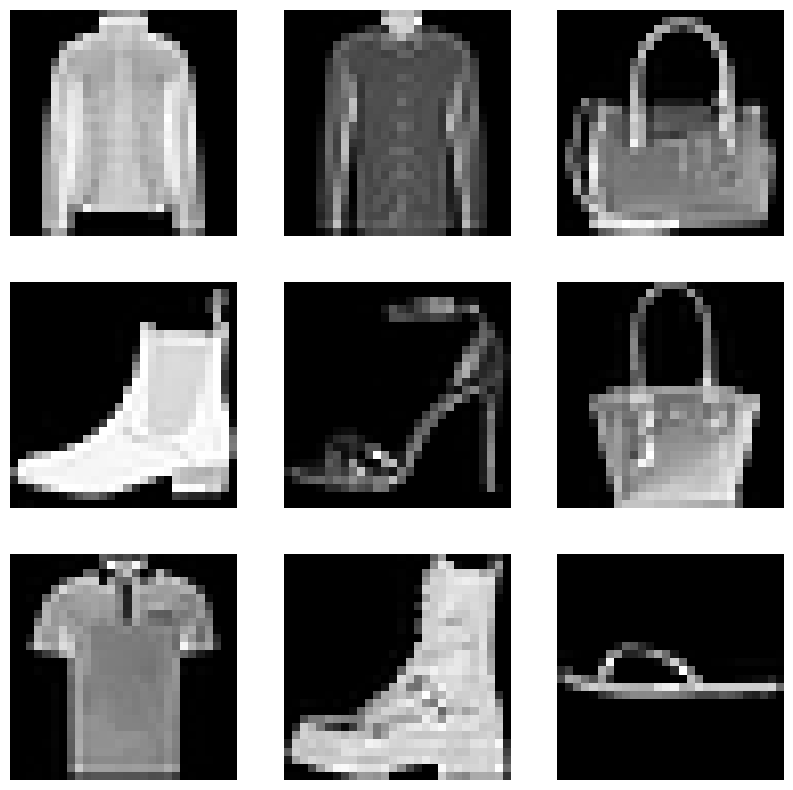

In [24]:

# visualisation batch, to track the performance of the model
vis_batch, classes = next(iter(TestLoader))

visualize_predictions(vis_batch)

In [25]:
img1 = vis_batch[0].unsqueeze(0)
img2 = vis_batch[1].unsqueeze(0)

In [26]:
img1_hat, _, _, _ = model(img1.to(device))
img2_hat, _, _, _ = model(img2.to(device))

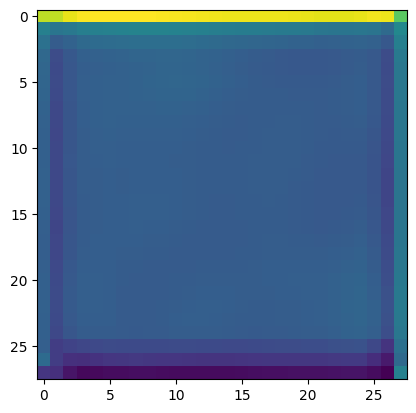

In [28]:
plt.imshow(img1_hat[0,0].detach().cpu())

In [29]:
def evaluate_model(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (images, classes) in val_loader:
            inputs = images.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            
            # Loss and backward
            loss = F.mse_loss(inputs, outputs)
            
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(TestLoader.dataset)

    return epoch_val_loss


model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs, classes) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    # #track output precision progression every 10 epoch:
    # if (epoch%5 == 0 and epoch<50):
    #     output, _, _, _ = model( vis_batch.float() )
    #     recons_evolution.append(output)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")



  0%|          | 0/1875 [00:00<?, ?batch/s]

100%|██████████| 1875/1875 [00:23<00:00, 80.84batch/s, loss=0.0169]


Epoch 0: Train Loss: 0.2736


100%|██████████| 1875/1875 [00:20<00:00, 92.35batch/s, loss=0.0149] 


Epoch 1: Train Loss: 0.0150


100%|██████████| 1875/1875 [00:23<00:00, 79.52batch/s, loss=0.0113] 


Epoch 2: Train Loss: 0.0129


100%|██████████| 1875/1875 [00:20<00:00, 93.23batch/s, loss=0.0118] 


Epoch 3: Train Loss: 0.0118


100%|██████████| 1875/1875 [00:21<00:00, 86.85batch/s, loss=0.012]  


Epoch 4: Train Loss: 0.0110


100%|██████████| 1875/1875 [00:21<00:00, 88.62batch/s, loss=0.0122]  


Epoch 5: Train Loss: 0.0104


100%|██████████| 1875/1875 [00:22<00:00, 83.07batch/s, loss=0.0105] 


Epoch 6: Train Loss: 0.0100


100%|██████████| 1875/1875 [00:22<00:00, 83.72batch/s, loss=0.00965]


Epoch 7: Train Loss: 0.0098


100%|██████████| 1875/1875 [00:21<00:00, 86.38batch/s, loss=0.00806]


Epoch 8: Train Loss: 0.0097


100%|██████████| 1875/1875 [00:21<00:00, 86.18batch/s, loss=0.0091] 


Epoch 9: Train Loss: 0.0097
Training complete.


In [30]:
def plot_train_val_loss(train_loss_values, val_loss_values ):
    # Plot the training and validation losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Evolution of Loss')
    plt.legend()
    plt.grid()
    plt.show()


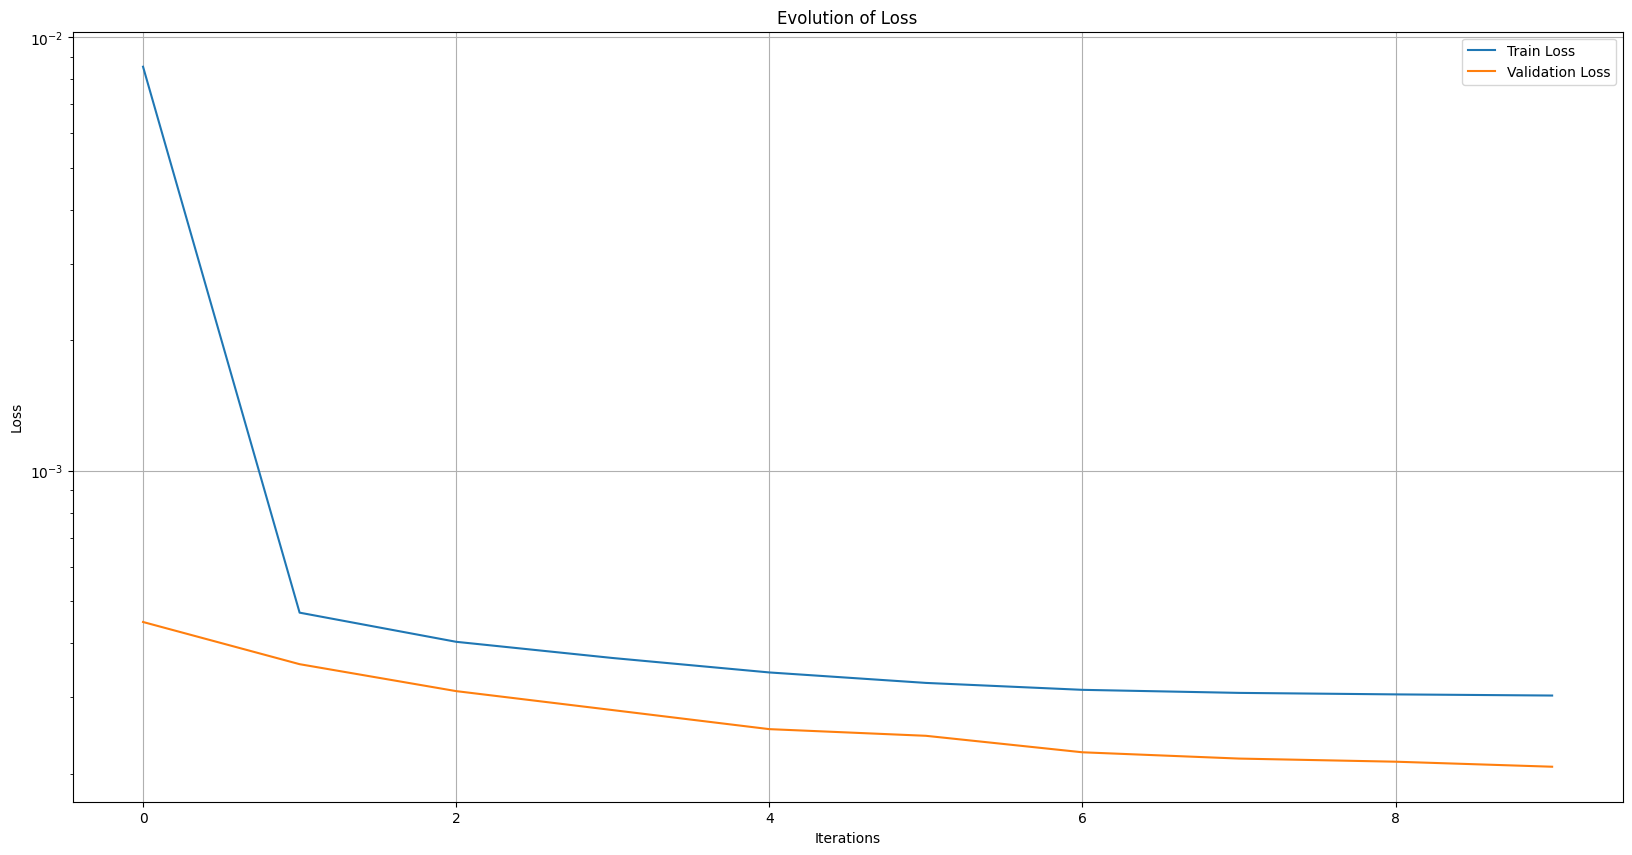

In [31]:
plot_train_val_loss(train_loss_values, val_loss_values)

In [37]:
def save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values):
    checkpoint_path = os.path.join( os.getcwd() , model_name )
    torch.save({'epoch' : epoch,
                'K' : model.vq_layer.K,
                'D' :  model.vq_layer.D,
                'model_state_dict' : model.state_dict(),
                'train_loss_values' : train_loss_values, 
                'val_loss_values' : val_loss_values, 
                'codebook_loss_values' : codebook_loss_values,
                'codebook' : model.vq_layer.embedding.weight.data }, checkpoint_path)

save_path = "saved_models/model_101.pth"
save_model(save_path, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

In [32]:
def visualize_errors(true_seg, pred_seg, title):
    # batch_size = batch.shape[0]
    samples = 8

    fig, axes = plt.subplots(samples, 2, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)


    for i in range(samples):
        axes[i,0].imshow(true_seg[i].squeeze(), cmap = 'gray')
        axes[i,0].axis('off')

        axes[i,1].imshow(pred_seg[i].squeeze(),cmap = 'gray')
        axes[i,1].axis('off')


    row_titles = ['Ground truth', 'Vq-Vae predictions']
    for i in range(2):
        axes[0, i].set_title(row_titles[i], fontsize=14, fontweight='bold')
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

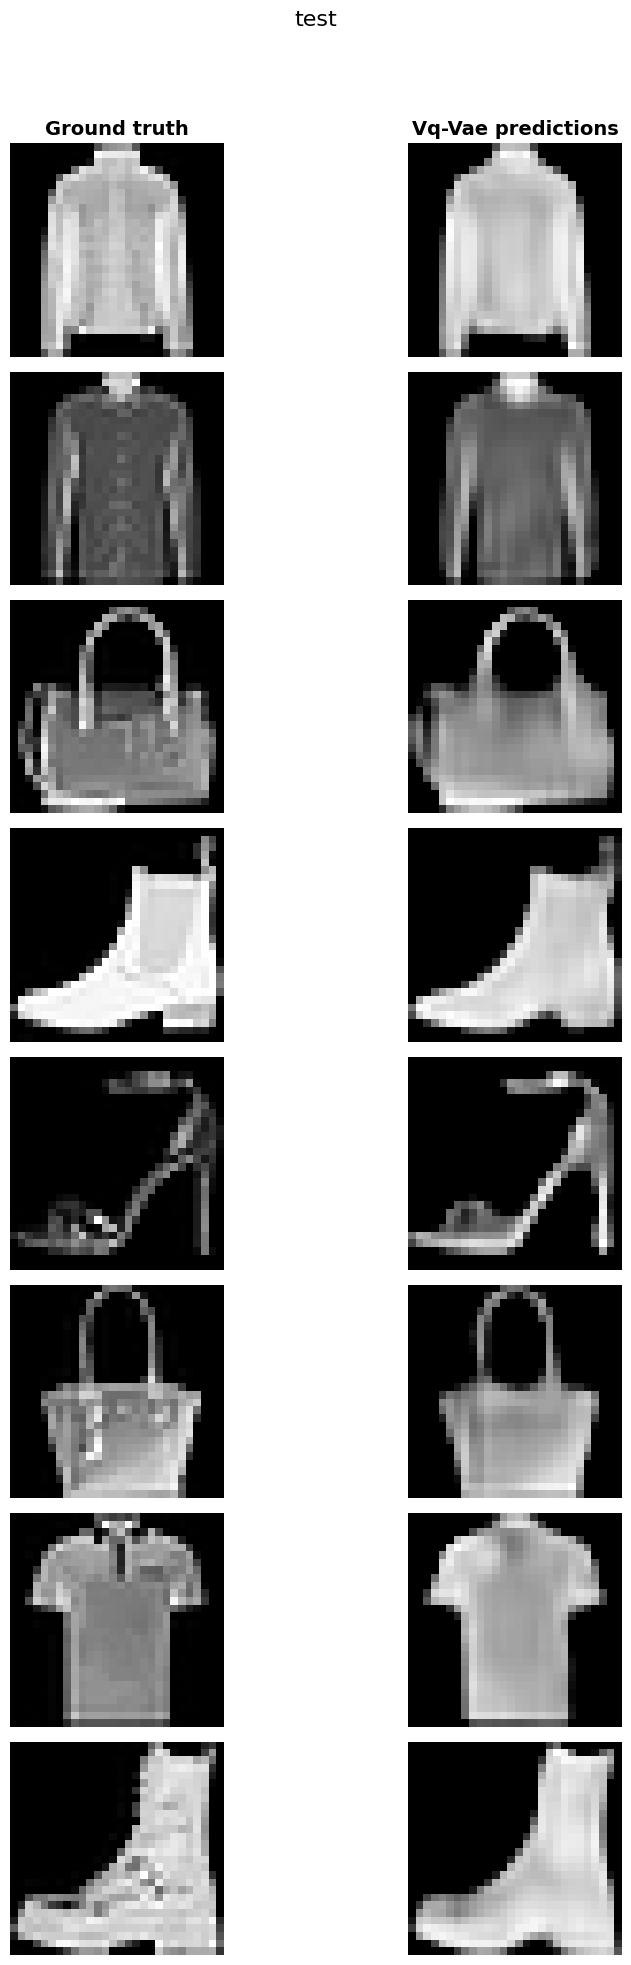

In [33]:
vis_batch.detach().cpu()
batch_hat,_,_,_ = model(vis_batch.to(device))
batch_hat = batch_hat.detach().cpu()

visualize_errors(vis_batch, batch_hat, 'test')